In [60]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
import gym
import gym_anytrading
import talib
from stable_baselines.common.vec_env import DummyVecEnv

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import A2C
from stable_baselines import PPO2
from stable_baselines import SAC

import warnings
warnings.filterwarnings('ignore')

In [61]:
def trainA2C(policy,env,timesteps=25000,verbose=0):
    model=A2C(policy,env,verbose)
    model.learn(total_timesteps=timesteps)
    return model

In [62]:
def trainSAC(env,timesteps=50000):
    model=SAC('MlpPolicy',env,verbose=1)
    model.learn(total_timesteps=timesteps)
    return model

In [63]:
def trainPPO(env,timesteps=50000):
    model=PPO2('MlpPolicy',env,ent_coef=0.005)
    model.learn(total_timesteps=timesteps)
    return model

In [64]:
def load_dataset(ticker,startDate,endDate):
    data=web.DataReader(ticker,data_source='yahoo',start=startDate,end=endDate)
    return data

In [65]:
def add_technical_indicator(df):
    """
     calculate technical indicators
     use talib package to add technical indicators
     :param data: (df) pandas dataframe
     :return: (df) pandas dataframe
    """
    adjClose=df['Adj Close']
    
    macd,macdsignal,macdhist=talib.MACD(adjClose,fastperiod=12,slowperiod=26,signalperiod=9)
    
    rsi=talib.RSI(adjClose,timeperiod=12)
    
    upper,middle,lower=talib.BBANDS(adjClose,timeperiod=20,nbdevup=2.0,nbdevdn=2.0,matype=talib.MA_Type.EMA)
    
    ROC=talib.ROC(adjClose,timeperiod=12)
    
    df=df.assign(**{'RSI':rsi,'MACD':macd,'macd_signal':macdsignal,'macd_hist':macdhist,'UPPER_BB':upper,'LOWER_BB':lower,'MIDDLE_BB':middle,'ROC':ROC})
    
    return df
    

In [66]:
def preprocess_data(df):
    """
    Data preprocessing pipeline
    """
    df=add_technical_indicator(df)
    df.fillna(0,inplace=True)
    df['pred_price']=df['Adj Close'].shift(-6)
    return df

In [67]:
data=load_dataset('AAPL',startDate="2006-01-01",endDate="2021-01-01")

In [68]:
data=preprocess_data(data)

In [69]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,RSI,MACD,macd_signal,macd_hist,UPPER_BB,LOWER_BB,MIDDLE_BB,ROC,pred_price
Date,,,,,,,,,,,,,,,
2006-01-03,2.669643,2.580357,2.585000,2.669643,807234400.0,2.299533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.581014
2006-01-04,2.713571,2.660714,2.683214,2.677500,619603600.0,2.306301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.593012
2006-01-05,2.675000,2.633929,2.672500,2.656429,449422400.0,2.288151,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.633004
2006-01-06,2.739286,2.662500,2.687500,2.725000,704457600.0,2.347216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.605932
2006-01-09,2.757143,2.705000,2.740357,2.716071,675040800.0,2.339525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.537638


In [70]:
env=gym.make('stocks-v0',df=data,frame_bound=(7,400),window_size=7)

In [71]:
env.signal_features

array([[ 2.66964293e+00,  0.00000000e+00],
       [ 2.67750001e+00,  7.85708427e-03],
       [ 2.65642905e+00, -2.10709572e-02],
       [ 2.72499990e+00,  6.85708523e-02],
       [ 2.71607089e+00, -8.92901421e-03],
       [ 2.88785696e+00,  1.71786070e-01],
       [ 2.99642897e+00,  1.08572006e-01],
       [ 3.01035690e+00,  1.39279366e-02],
       [ 3.05678606e+00,  4.64291573e-02],
       [ 3.02535701e+00, -3.14290524e-02],
       [ 2.94607091e+00, -7.92860985e-02],
       [ 2.82285690e+00, -1.23214006e-01],
       [ 2.71749997e+00, -1.05356932e-01],
       [ 2.77392912e+00,  5.64291477e-02],
       [ 2.71571398e+00, -5.82151413e-02],
       [ 2.65000010e+00, -6.57138824e-02],
       [ 2.58321404e+00, -6.67860508e-02],
       [ 2.57249999e+00, -1.07140541e-02],
       [ 2.67857099e+00,  1.06070995e-01],
       [ 2.69678593e+00,  1.82149410e-02],
       [ 2.69357109e+00, -3.21483612e-03],
       [ 2.57500005e+00, -1.18571043e-01],
       [ 2.56607103e+00, -8.92901421e-03],
       [ 2.

In [72]:
env.action_space

Discrete(2)

info {'total_reward': 1.8146439790725708, 'total_profit': 0.40011860315153436, 'position': 0}


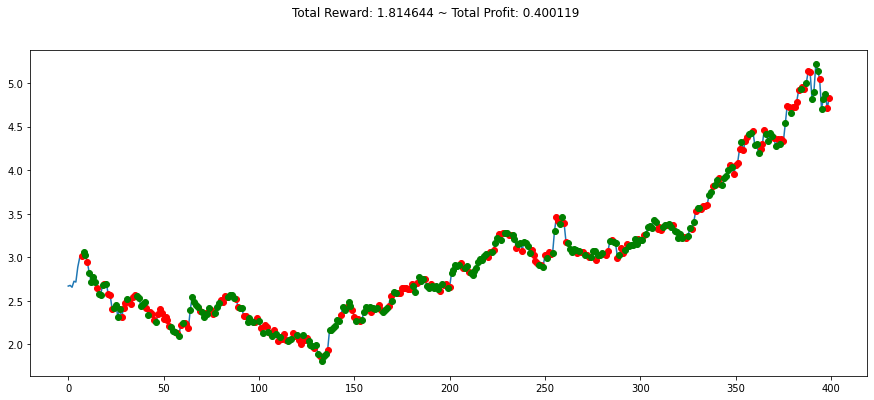

In [73]:
state=env.reset()
while True:
    action=env.action_space.sample()
    n_state,reward,done,info=env.step(action)
    if done:
        print("info",info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [74]:
from gym_anytrading.envs import StocksEnv

In [75]:
def add_signals(env):
    start=env.frame_bound[0]-env.window_size
    end=env.frame_bound[1]
    prices=env.df.loc[:,'Adj Close'].to_numpy()[start:end]
    signal_features=env.df.loc[:,['Adj Close','RSI','MACD','UPPER_BB','LOWER_BB','MIDDLE_BB','ROC']].to_numpy()[start:end]
    return prices,signal_features

In [76]:
class CustomEnv(StocksEnv):
    _process_data=add_signals
    
env2=CustomEnv(df=data,window_size=12,frame_bound=(12,300))

In [77]:
env2.signal_features

array([[ 2.29953313e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.30630064e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.28815055e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.76466918e+00,  6.06338148e+01,  1.54805681e-02, ...,
         2.56673056e+00,  2.68102685e+00,  4.02158862e-01],
       [ 2.71944785e+00,  5.45267746e+01,  1.64748179e-02, ...,
         2.57190060e+00,  2.68468599e+00, -7.52185943e-01],
       [ 2.76866889e+00,  5.93842078e+01,  2.09925060e-02, ...,
         2.57785398e+00,  2.69268436e+00,  1.68345507e+00]])

In [54]:
env_maker=lambda: env2
env=DummyVecEnv([env_maker])

In [81]:
model = trainA2C(policy='MlpPolicy',env=env,timesteps=40000,verbose=0)

In [82]:
env = CustomEnv(df=data, window_size=12, frame_bound=(300,750))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 0.0015239715576171875, 'total_profit': 0.3135541907005263, 'position': 0}


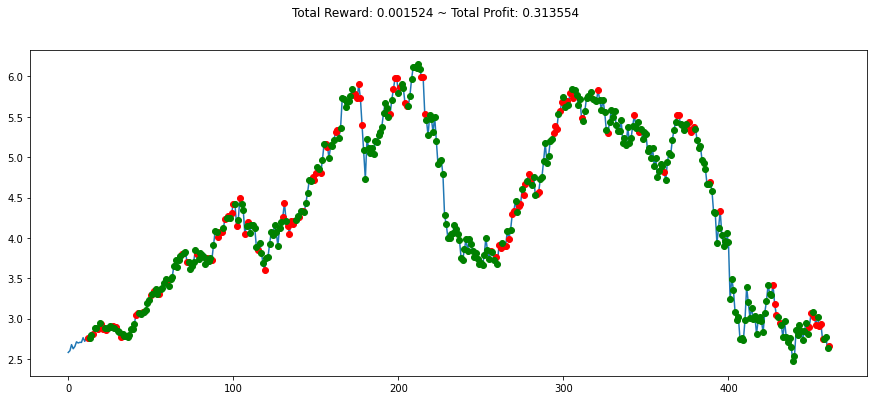

In [83]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

Discrete(2)
